In [212]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi

# *Read Gambar*

Membaca gambar yang dimasukan lalu mengonversi representasi warna citra dari format BGR (yang digunakan oleh OpenCV) ke format RGB (yang digunakan oleh matplotlib) menggunakan fungsi cv2.cvtColor

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19512\4206923791.py:2: SyntaxWarning: invalid escape sequence '\i'
  image_path = "Testdata\im0002.ppm"


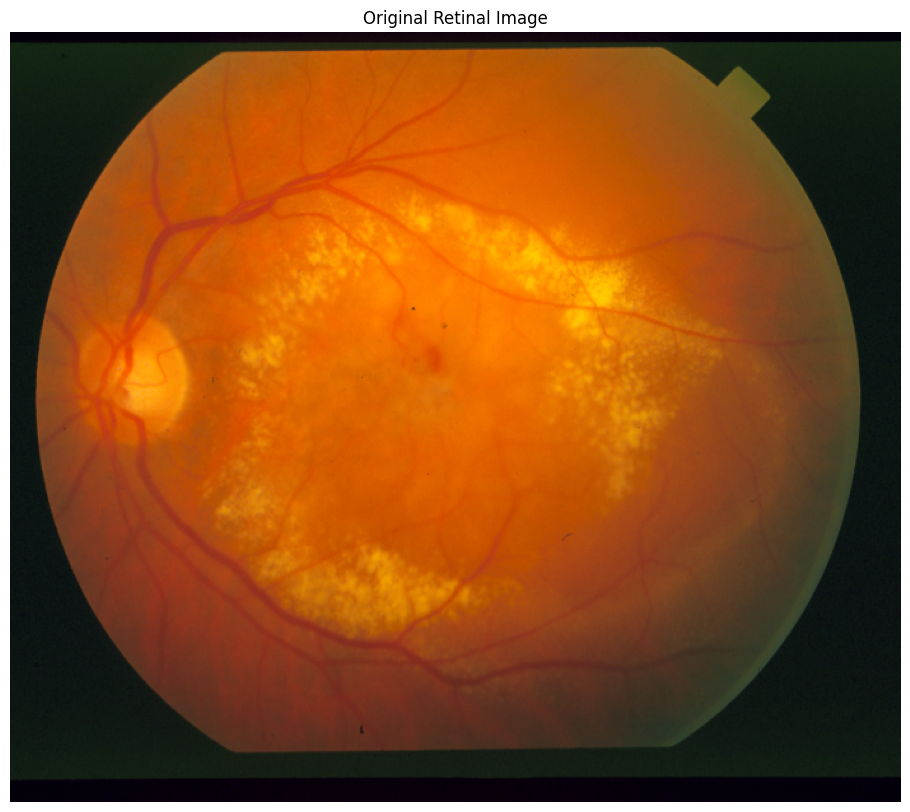

In [213]:
# Membaca gambar dari path yang diberikan
image_path = "Testdata\im0002.ppm"
raw_image_bgr = cv2.imread(image_path)

# Mengubah gambar dari BlueGreenRed (OpenCV format) ke RedGreenBlue (matplotlib format)
raw_image_rgb = cv2.cvtColor(raw_image_bgr, cv2.COLOR_BGR2RGB)

# Menampilkan gambar asli (Raw Image)
plt.figure(figsize=(20, 10))
plt.title("Original Retinal Image")
plt.imshow(raw_image_rgb)
plt.axis('off')
plt.show()

# MASKING GAMBAR

 membuat sebuah masker lingkaran dengan ukuran yang sesuai dengan dimensi citra asli raw_image, lalu menerapkan masker tersebut pada citra asli menggunakan operasi bitwise AND. Hasilnya adalah sebuah citra baru masked_image yang hanya menampilkan area lingkaran dari citra asli, sementara area di luar lingkaran diubah menjadi hitam.

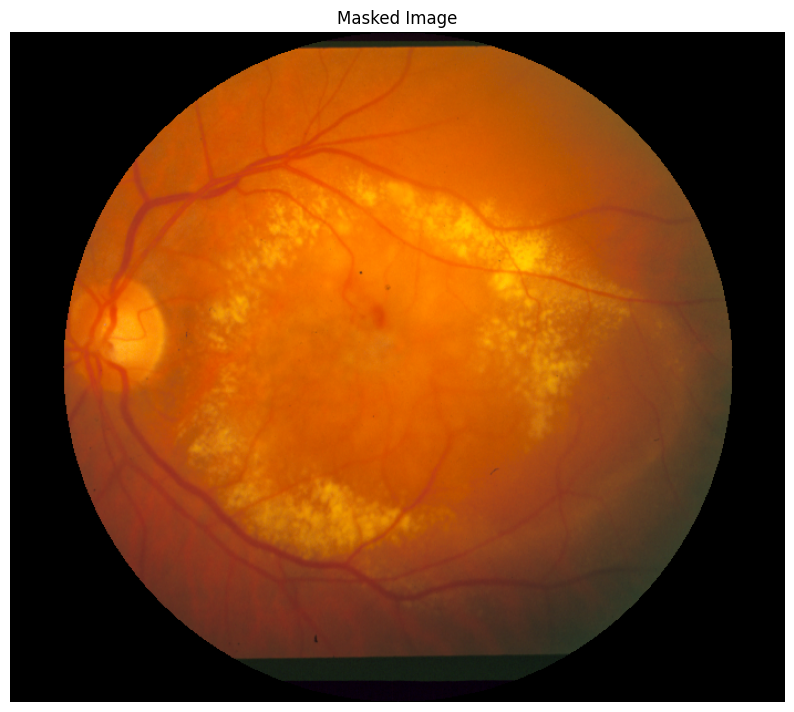

In [214]:
# Membuat masker dengan ukuran yang sama dengan gambar
mask = np.zeros(raw_image_bgr.shape[:2], dtype="uint8")

# Mnentukan pusat dan radius lingkaran yang akan digambar di masker
(h, w) = raw_image_bgr.shape[:2]
center = (w // 2, h // 2)
radius = min(center[0], center[1], w - center[0], h - center[1])

# Menggambar lingkaran putih di tengah masker hitam (0) dengan radius tertentu
for i in range(h):
    for j in range(w):
        if (i - center[1])**2 + (j - center[0])**2 <= radius**2:
            mask[i, j] = 255

masked_image = cv2.bitwise_and(raw_image_rgb, raw_image_rgb, mask=mask)

plt.figure(figsize=(10, 10))
plt.title("Masked Image")
plt.imshow(masked_image)
plt.axis('off')
plt.show()


# Vessel Detecting using Frangi

### Gray Filter
mengekstrak saluran warna hijau (green channel) dari citra masked_image dan menyimpannya sebagai citra grayscale gray_image2. Notasi [:,:,1] adalah slicing dalam NumPy yang mengambil semua baris dan kolom dari dimensi ketiga (di sini adalah saluran warna) dengan indeks 1, yang merepresentasikan saluran hijau dalam format warna RGB.

In [215]:
gray_image_frangi = masked_image[:,:,1]

### CLAHE

1. membuat objek CLAHE (Contrast Limited Adaptive Histogram Equalization) dengan parameter clip limit 2.0 dan ukuran grid 8x8 untuk meningkatkan kontras citra
2. menerapkan CLAHE pada citra grayscale gray_image2 untuk menghasilkan citra equalized dengan kontras yang lebih baik
3. menghilangkan noise pada citra equalized menggunakan metode denoising Non-local Means dengan ukuran jendela template 15, menghasilkan citra denoised yang memiliki kontras yang ditingkatkan dan noise yang berkurang.

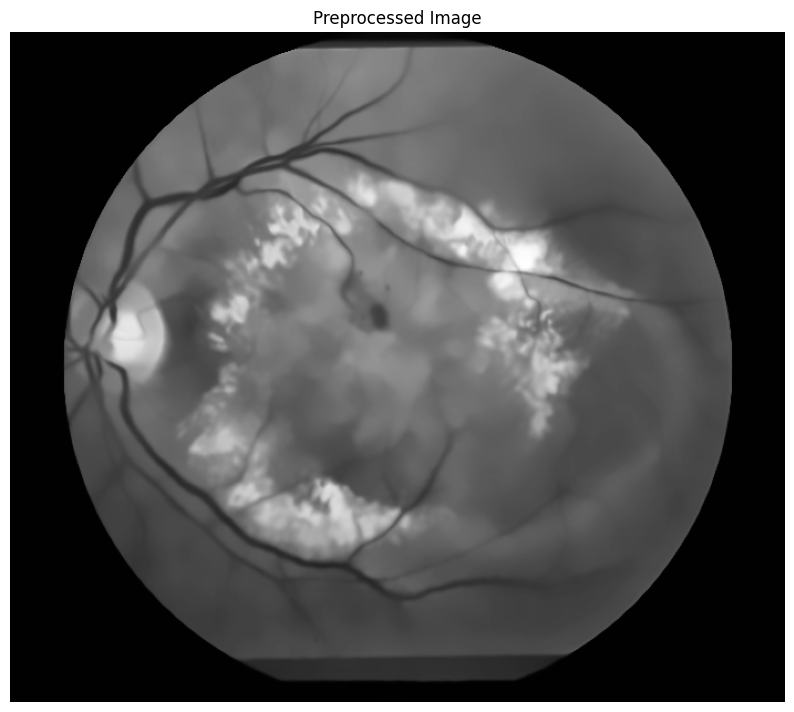

In [216]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray_image_frangi)
denoised = cv2.fastNlMeansDenoising(equalized, None, 15)

plt.figure(figsize=(10, 10))
plt.title("Preprocessed Image")
plt.imshow(denoised, cmap='gray')
plt.axis('off')
plt.show()

### Frangi to normalize
 normalisasi pada citra dengan mengalikan setiap piksel dalam citra dengan rasio antara factor dan nilai piksel maksimum dalam citra. Hasilnya adalah citra yang memiliki nilai piksel maksimum sama dengan factor, sehingga rentang nilai piksel dalam citra tersebut dinormalisasi ke rentang baru yang ditentukan oleh factor. Fungsi ini mengembalikan citra yang telah dinormalisasi sebagai array NumPy.

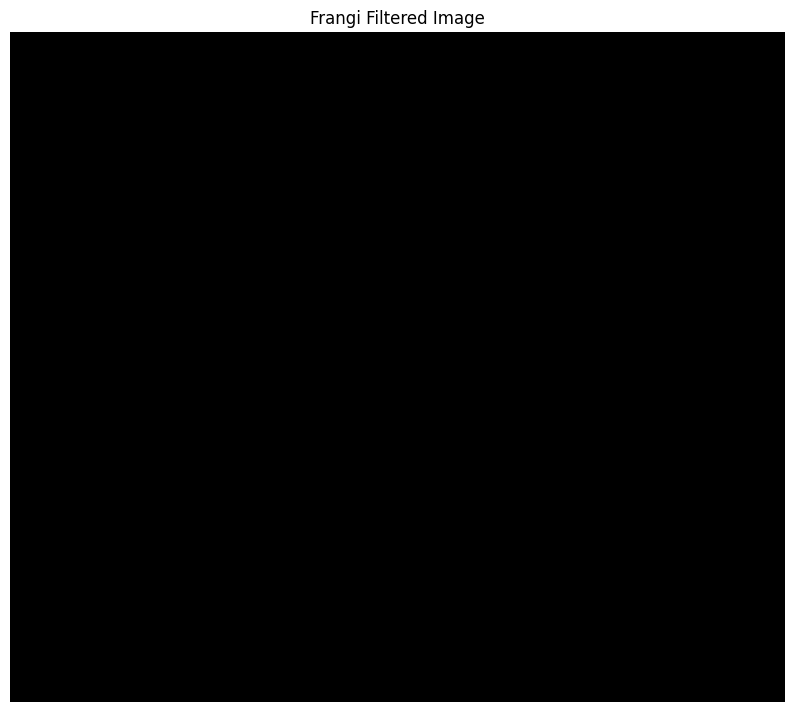

In [217]:
def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

vessels1 = frangi(denoised)
vessels = normalize(vessels1, 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.title("Frangi Filtered Image")
plt.imshow(vessels1, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

### Finding Threshold
melakukan operasi thresholding pada citra vessels. Thresholding adalah proses mengonversi citra grayscale menjadi citra biner dengan mengubah setiap piksel menjadi hitam (0) atau putih (255) berdasarkan nilai ambang batas tertentu. Dalam kasus ini, nilai ambang batas adalah 0, artinya semua piksel dengan nilai lebih besar dari 0 akan diubah menjadi 255 (putih), sementara piksel dengan nilai 0 akan tetap 0 (hitam). Operasi ini menghasilkan citra biner thresh yang merepresentasikan objek-objek dalam citra vessels sebagai area putih pada latar belakang hitam.

(-0.5, 699.5, 604.5, -0.5)

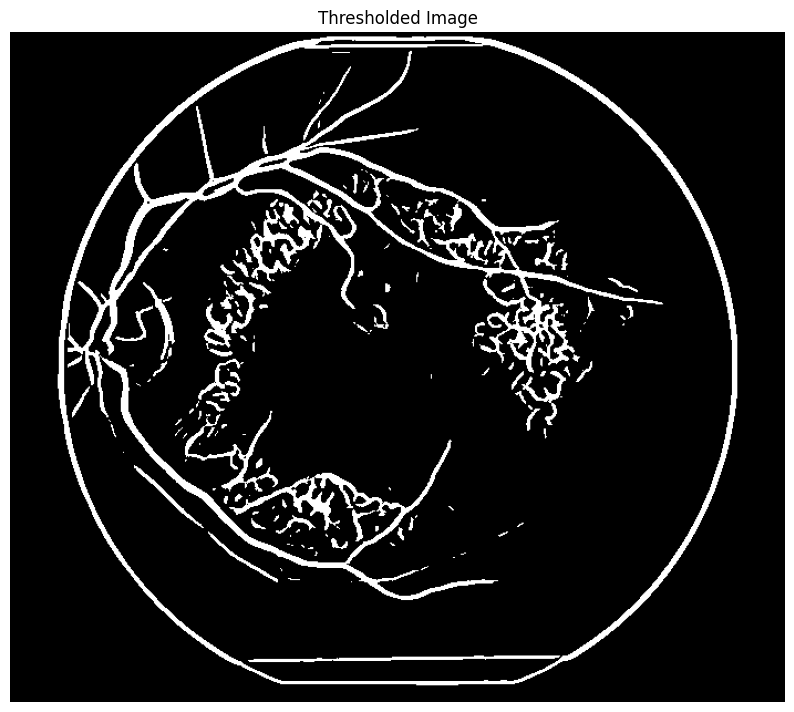

In [218]:
_, thresh = cv2.threshold(vessels, 0, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 10))
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

### Hapus Small Elements
 mengambil citra biner dan nilai ambang batas ukuran sebagai input, menggunakan algoritma Connected Component Labeling dari OpenCV untuk melabeli objek-objek terhubung dalam citra, menghapus objek-objek yang ukurannya lebih kecil dari ambang batas ukuran serta mempertahankan objek-objek dengan lebar atau tinggi di atas 150 piksel, dan mengembalikan citra baru dengan elemen-elemen kecil yang telah dihapus. Pada baris terakhir, fungsi ini dipanggil dengan citra biner thresh dan ambang batas ukuran 800, dan hasilnya dikonversi ke tipe data np.uint8

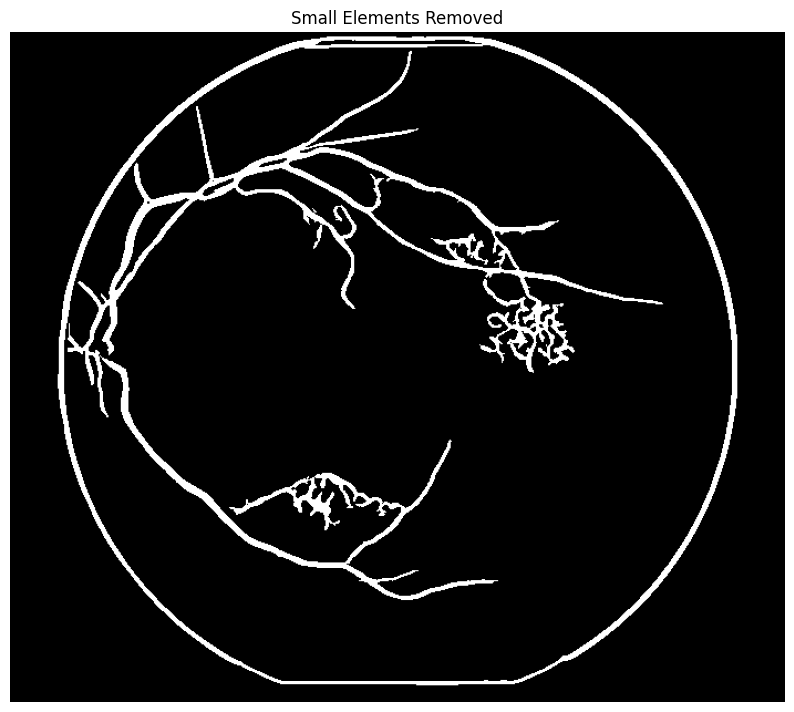

In [219]:
def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv2.connectedComponentsWithStats(
        image, connectivity=8)

    sizes = stats[1:, -1]
    width = stats[1:, -3]
    height = stats[1:, -2]
    components -= 1

    result = np.zeros((output.shape))

    for i in range(0, components):
        if sizes[i] >= min_size and (width[i] > 150 or height[i] > 150):
            result[output == i + 1] = 255

    return result

small_removed_frangi = remove_small_elements(thresh, 800).astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.title("Small Elements Removed")
plt.imshow(small_removed_frangi, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

### Remove Border
mengambil dua input: color_img yang merupakan citra berwarna dan image yang merupakan citra biner. Fungsi ini bertujuan untuk menghapus objek-objek di sekitar batas citra berwarna.

1. mengonversi citra berwarna dari format BGR ke RGB
2. mendefinisikan rentang nilai warna lower dan upper dalam ruang warna HSV untuk mendeteksi objek-objek yang ingin dipertahankan
3. membuat masker biner menggunakan cv2.inRange yang hanya memasukkan piksel-piksel yang berada dalam rentang warna yang didefinisikan,
4. menerapkan operasi bitwise AND antara citra biner image dan masker untuk mendapatkan hasil akhir yang hanya berisi objek-objek di dalam batas citra berwarna.

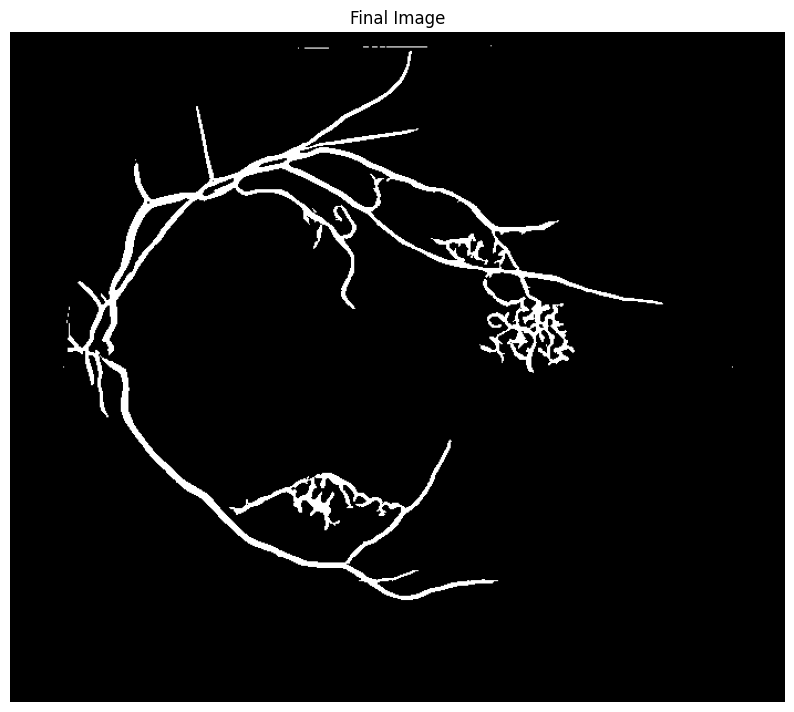

In [220]:
def remove_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    RGB = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(RGB, lower, upper)
    
    return cv2.bitwise_and(image, mask)

end_result_frangi = remove_border(masked_image, small_removed_frangi)

plt.figure(figsize=(10, 10))
plt.title("Final Image")
plt.imshow(end_result_frangi,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()

# Vessel Detecting Canny

Manual Gray Image

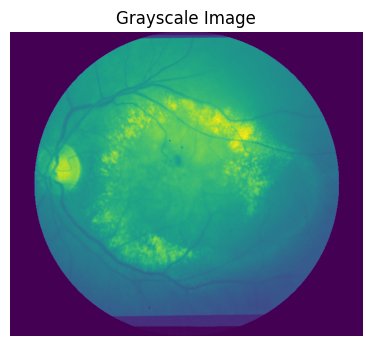

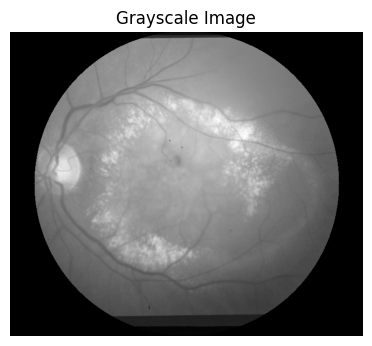

In [221]:
# Konversi gambar ke grayscale secara manual
gray_image = np.zeros((h, w), dtype="float32")
for i in range(h):
    for j in range(w):
        if mask[i, j] == 255:
            R = masked_image[i, j, 0]
            G = masked_image[i, j, 1]
            B = masked_image[i, j, 2]
            gray_value = 0.2989 * R + 0.5870 * G + 0.1140 * B
            gray_image[i, j] = np.clip(gray_value, 0, 255) 

gray_image = (gray_image * 255 / gray_image.max()).astype("uint8")
# Menampilkan gambar grayscale
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(gray_image, vmin=0, vmax=255)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(gray_image,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()

Adaptive Histogram Equalization (CLAHE)

(-0.5, 699.5, 604.5, -0.5)

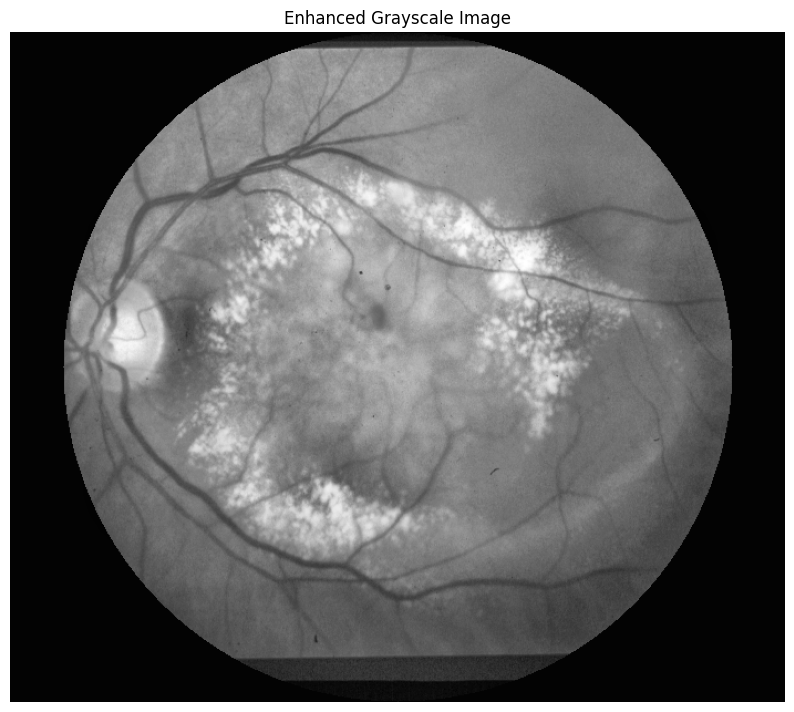

In [222]:

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray_image = clahe.apply(gray_image)

plt.figure(figsize=(10, 10))
plt.title("Enhanced Grayscale Image")
plt.imshow(enhanced_gray_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')


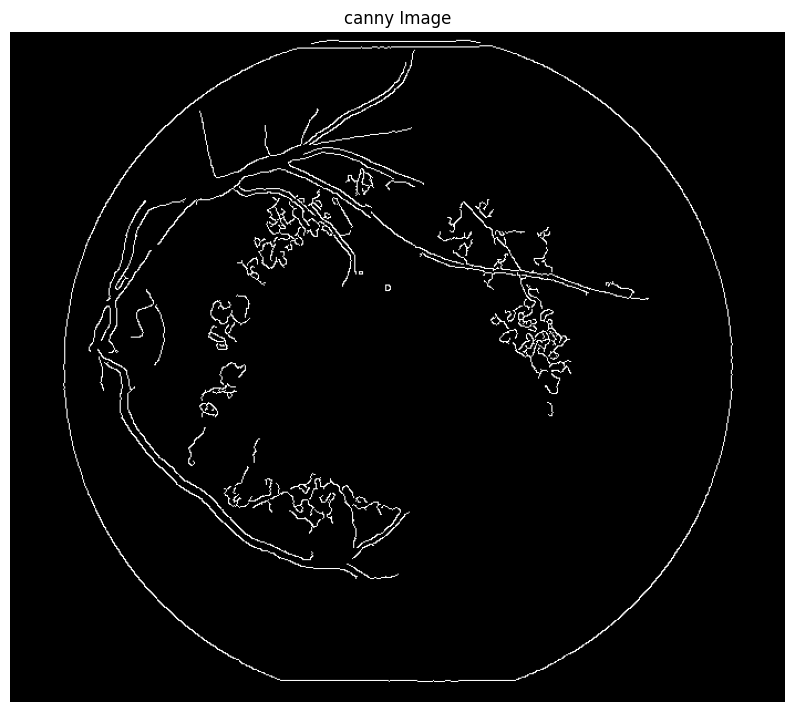

In [223]:
blurred_image = cv2.GaussianBlur(enhanced_gray_image, (5, 5), 0)
vessel_image = cv2.Canny(blurred_image, 50, 150)

plt.figure(figsize=(10, 10))
plt.title("canny Image")
plt.imshow(vessel_image, cmap='gray')
plt.axis('off')
plt.show()

(-0.5, 699.5, 604.5, -0.5)

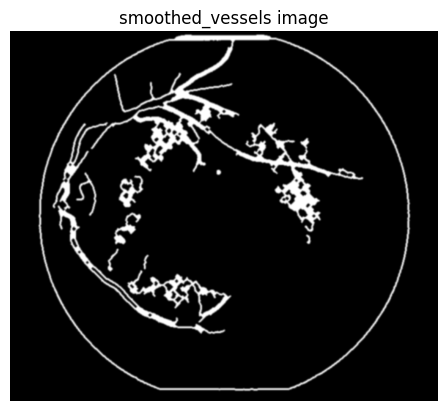

In [224]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

morph_image = cv2.morphologyEx(vessel_image, cv2.MORPH_GRADIENT, kernel)

dilated = cv2.dilate(morph_image, kernel, iterations=1)

closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=1)

eroded = cv2.erode(closing, kernel, iterations=1)

smoothed_vessels_canny = cv2.GaussianBlur(eroded, (5, 5), 0)

plt.title("smoothed_vessels image")
plt.imshow(smoothed_vessels_canny, cmap='gray')
plt.axis('off')

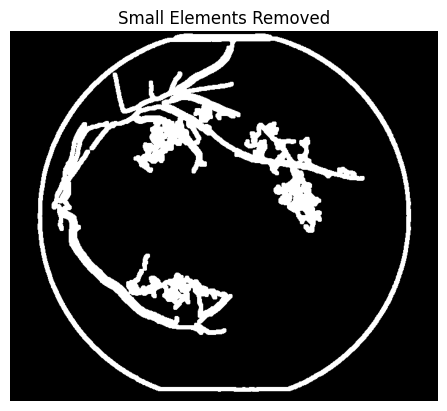

In [225]:

small_remove_canny = remove_small_elements(smoothed_vessels_canny,800).astype(np.uint8)

plt.title("Small Elements Removed")
plt.imshow(small_remove_canny, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

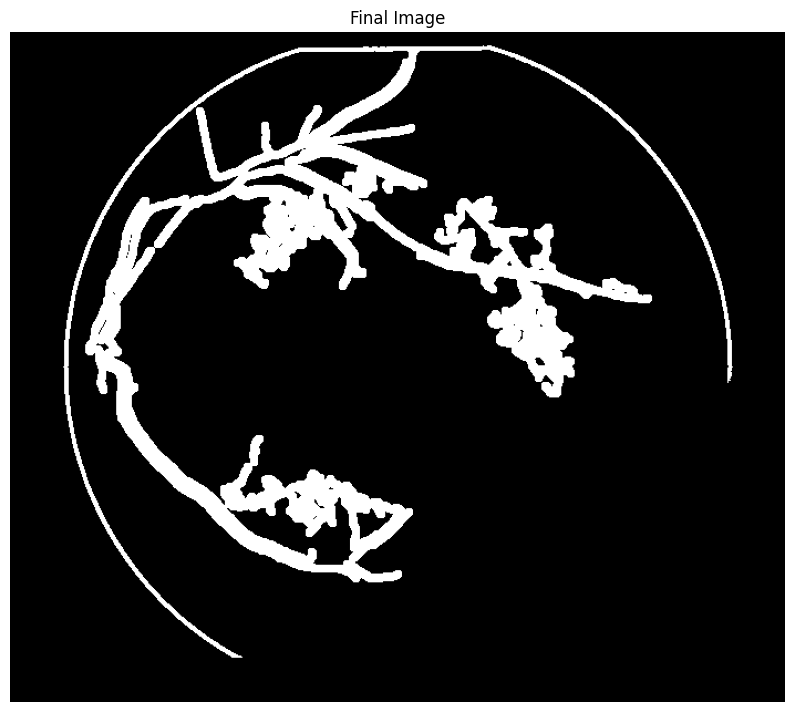

In [226]:
end_result_canny = remove_border(masked_image, small_remove_canny)

plt.figure(figsize=(10, 10))
plt.title("Final Image")
plt.imshow(end_result_canny,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()


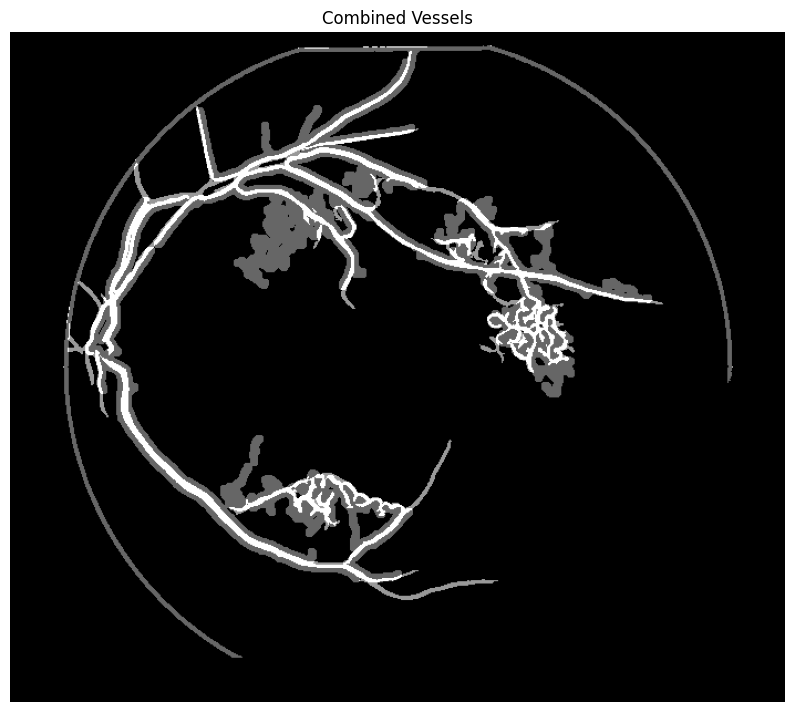

In [228]:
combined_vessels = cv2.addWeighted(end_result_frangi, 0.6, end_result_canny, 0.4, 0)
plt.figure(figsize=(10, 10))
plt.title("Combined Vessels")
plt.imshow(combined_vessels, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()